# **Compulsory Assignment 1**
## *Machine Learning and Deep Learning (CDSCO2041C)*
*Group: MLS26_CA01*

*Student IDs: 185912, 161989, 160363 & xxx*

*Dataset: greenhouse-gas-emissions.xlsx*

---

## Question 1
### Exploratory Data Analysis (EDA)
The provided dataset contains UK territorial greenhouse gas emissions by source and activity, cover-
ing the period from 1990 onwards. Emissions are attributed to the sector that emits them directly
and include indicators related to UK territorial totals, international aviation and shipping, and Paris
Agreement coverage.
Perform Exploratory Data Analysis (EDA) to investigate the key factors driving changes in UK
greenhouse gas emissions over time.
1. Write a Python program to perform a covariance- and correlation-based analysis to examine
relationships between emissions, sources, and activities across years. Do not use any built-in
covariance or correlation functions. You must implement your calculations.

2. Write another Python program to visualise your findings from the previous step and briefly
explain the observed emission patterns. Hints: You may consider using histograms, boxplots,
and scatterplots.

---

### Introduction

In this assignment, we analyse the covariance and correlation between different emission sectors and activities in order to understand how UK territorial greenhouse gas emissions co-move over time. Greenhouse gas emissions represent a multivariate time series structure, where sectoral developments may reflect shared economic drivers, structural transformation, or coordinated policy effects. By examining the statistical relationships between sectors, we aim to identify whether emission reductions have occurred uniformly across the economy or whether certain sectors exhibit distinct behavioural patterns.

This leads to our first research question:

**To what extent do UK territorial greenhouse gas emissions exhibit structural co-movement across sectors, and what does this reveal about the effectiveness and distribution of emission reductions under UK climate policy?**

Understanding co-movement is essential for assessing whether emission reductions reflect broad structural decarbonisation or are concentrated within specific high-impact sectors such as electricity supply or industry. If reductions are strongly correlated across sectors, this may indicate economy-wide structural change. Conversely, weaker or heterogeneous relationships may suggest uneven policy impact or sector-specific transition dynamics.

Under Question 2, we extend the analysis using unsupervised machine learning techniques. Rather than focusing solely on pairwise relationships, we examine whether subsectors can be grouped based on similarities in their full emission trajectories over time. This motivates our second research question:

**Can unsupervised clustering of emission trajectories identify structurally distinct groups of subsectors, and how do these clusters relate to UK Carbon Budget priorities?**

To answer these research questions, we first conduct exploratory data analysis. Emissions are aggregated to sector level and reshaped into a time series format suitable for statistical analysis. We compute covariance and correlation matrices using manually implemented formulas to ensure transparency and demonstrate understanding of the underlying statistical concepts. Because long-run emission trends may induce spurious correlations, we also analyse year-over-year changes to distinguish structural co-movement from common time dependence. Finally, we visualise emission trajectories and distributional patterns to support interpretation of the statistical results and to link our findings to climate policy developments.

Together, this structured approach combines statistical analysis, visual exploration, and unsupervised learning to provide a data-driven assessment of structural change in UK greenhouse gas emissions.

In [49]:
# Imports used in the notebook

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Markdown, display

In [50]:
# Load dataset
file_path = "Data/greenhouse-gas-emissions.xlsx"

# Load sheets
sheet2 = pd.read_excel(file_path, sheet_name=1)  # Variable descriptions
sheet3 = pd.read_excel(file_path, sheet_name=2)  # Emission data

In [51]:
# Initial Dataset Overview
# Inspect variable descriptions

# Clean column names
sheet2.columns = sheet2.columns.str.strip()

# Relevant columns only
variables_table = sheet2.iloc[:, :2]
variables_table.columns = ["Variable", "Description"]
variables_table

,Variable,Description
0,Included in UK territorial total,Identifies emissions included in the UK territ...
1,Included in UK UNFCCC total,Identifies emissions included in the territori...
2,Included in UK Paris Agreement total,Identifies emissions included in the territori...
3,GHG,"The greenhouse gas emitted, with different spe..."
4,GHG grouped,"The greenhouse gas emitted, with F-gases group..."
5,CRT category,Categories defined in international guidelines...
6,CRT category description,Text description for each CRT category.
7,Year,The calendar year in which the emissions occur...
8,Territory name,"The territory where the emissions occurred, ei..."
9,Territorial Emissions Statistics sector,A grouping of the TES subsectors and categories.


### Analysis of Policy-Relevant Emissions

UK Carbon Budgets and official progress assessments are based on territorial emissions, meaning emissions that occur within the UK’s geographic boundaries. To ensure that the statistical analysis is aligned with the policy framework and carbon accounting methodology, we restrict the dataset to observations included in the UK territorial total. This step ensures that subsequent covariance and correlation results reflect structurally relevant emission dynamics rather than memo items or internationally reported components that are treated separately in climate policy.

Rather than analysing hundreds of highly granular emission sources, we aggregate emissions to the top-level Territorial Emissions Statistics sectors. This aggregation improves interpretability, reduces dimensionality, and ensures that the covariance structure captures meaningful sector-level relationships rather than noise from very small individual sources. The sector-level aggregation reflects structured combinations of underlying sources and activities. Each sector is composed of multiple emission sources and fuel or activity categories, meaning that sectoral time series capture broader structural emission dynamics rather than isolated micro-level processes.

In [52]:
# EDA of emission data

# Basic shape of dataset
print("Rows, columns:", sheet3.shape)

# Year coverage
print("Years:", sheet3["Year"].min(),
      "→", sheet3["Year"].max(),
      "| n =", sheet3["Year"].nunique())

# Structural overview
print("Unique sectors:",
      sheet3["Territorial Emissions Statistics sector"].nunique())
print("Unique subsectors:",
      sheet3["Territorial Emissions Statistics subsector"].nunique())
print("Unique sources:",
      sheet3["Source"].nunique())
print("Unique fuel groups:",
      sheet3["Fuel group"].nunique())

# Missing values check
print("Missing emission values:",
      sheet3["Emissions (MtCO2e)"].isna().sum())

sheet3.describe()

Rows, columns: (78022, 15)
Years: 1990 → 2024 | n = 35
Unique sectors: 9
Unique subsectors: 28
Unique sources: 700
Unique fuel groups: 5
Missing emission values: 0


,Year,Emissions (MtCO2e)
count,78022.000000,78022.000000
mean,2007.771295,0.293069
std,9.982078,3.036902
min,1990.000000,-18.002028
25%,1999.000000,0.000124
50%,2008.000000,0.002087
75%,2016.000000,0.026358
max,2024.000000,184.014756


In [53]:

# Column name for top-level sector classification
SECTOR_COL = "Territorial Emissions Statistics sector"

# Restrict dataset to emissions included in the UK territorial total
# This aligns the analysis with UK Carbon Budget accounting principles
territorial = sheet3[
    sheet3["Included in UK territorial total"].str.lower() == "yes"
].copy()

# Aggregate emissions to sector level for each year
# This reduces dimensionality and creates annual sector-level time series
sector_year = (
    territorial
    .groupby(["Year", SECTOR_COL], as_index=False)["Emissions (MtCO2e)"]
    .sum()
)

### Reshaping the Data to Wide Format (Years × Sectors)

To compute covariance and correlation across sectors, the dataset must be structured such that each sector constitutes a separate variable observed across a common set of time periods. In the original long format, emissions are indexed by year and sector, which is not directly suitable for multivariate statistical analysis. We therefore reshape the dataset into wide format, where rows represent years and columns represent aggregated sectors.

In this representation, each column corresponds to a sector-specific emission time series, and each row represents an observation in time. This structure allows us to compute pairwise covariance and correlation across sectors and to examine whether emission trajectories exhibit systematic co-movement over the 1990–2024 period.

In [54]:
# Reshaping the Data to Wide Format (Years × Sectors)

# Pivot to wide format
pivot_sec = (
    sector_year
    .pivot(index="Year",
           columns=SECTOR_COL,
           values="Emissions (MtCO2e)")
    .fillna(0.0)
    .sort_index()
)

pivot_sec.head()

Territorial Emissions Statistics sector,Agriculture,Buildings and product uses,Domestic transport,Electricity supply,Fuel supply,Industry,LULUCF,Waste
Year,,,,,,,,
1990,54.988754,109.492561,124.191169,203.990902,77.192227,155.662400,10.266883,55.039201
1991,54.800121,121.292199,122.552535,200.562839,78.080868,156.665141,9.772005,56.836696
1992,54.457877,117.743777,123.850246,188.466186,79.240850,149.650442,8.962862,58.000423
1993,53.561508,121.671071,124.995984,170.963203,78.927561,143.356940,8.401128,59.475666
1994,54.320493,116.627834,125.175291,166.731982,71.448923,145.437790,7.925957,60.982346


### Covariance and Correlation Analysis

To examine whether sectoral emissions exhibit structural co-movement over time, we compute sample covariance and correlation across sector-level emission time series. Rather than relying on built-in functions, we manually implement the underlying formulas in order to ensure transparency of the statistical calculations and to demonstrate understanding of the methodological foundations discussed in Lecture 02.

For each sector, the annual emission series represents a variable observed over the period 1990–2024. The sample covariance between two sectors (x) and (y) is defined as:

$$
\text{cov}(x,y) = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})
$$

where (\bar{x}) and (\bar{y}) denote sample means. We use (n-1) to obtain the unbiased sample estimator. Covariance measures the magnitude of joint variation: large positive values indicate that sectors tend to increase or decrease together in absolute terms, while negative values indicate opposing movements.

However, covariance is scale-dependent. Large sectors such as electricity supply or industry naturally generate higher covariance values due to their greater emission levels and variability. To obtain a scale-independent measure, we compute the sample correlation:

$$
\text{corr}(x,y) = \frac{\text{cov}(x,y)}{s_x s_y}
$$

where (s_x) and (s_y) are the sample standard deviations. Correlation ranges between −1 and 1 and captures the strength and direction of linear co-movement across sectors. High positive correlations suggest coordinated structural change, while weaker correlations may indicate sector-specific dynamics.

### Addressing Spurious Trend Effects

Sectoral emissions exhibit strong long-run downward trends over the sample period. As a result, correlations computed on levels may partly reflect shared time dependence rather than genuine structural interaction. To distinguish common trending behaviour from synchronized short-run adjustments, we therefore also analyse year-over-year (YoY) changes. By computing covariance and correlation on first differences, we assess whether sectors co-move beyond their shared long-run decline.

This distinction is important for interpretation. Strong correlations in levels may reflect broad decarbonisation across the economy, whereas correlations in YoY changes provide evidence of whether reductions occur simultaneously across sectors or follow heterogeneous transition paths.

Together, the level-based and YoY-based analyses allow us to evaluate whether emission reductions in the UK reflect coordinated structural transformation or uneven sectoral adjustment. These findings form the empirical foundation for the subsequent clustering analysis.

In [55]:
# We implement the sample mean, variance, standard deviation,
# covariance, and correlation manually (ddof = 1).

def mean(xs):
    xs = list(xs)
    return sum(xs) / len(xs)

def variance(xs, ddof=1):
    xs = list(xs)
    n = len(xs)
    if n <= ddof:
        return float("nan")
    m = mean(xs)
    return sum((x - m) ** 2 for x in xs) / (n - ddof)

def std(xs, ddof=1):
    v = variance(xs, ddof=ddof)
    return math.sqrt(v) if not math.isnan(v) else float("nan")

def covariance(xs, ys, ddof=1):
    xs, ys = list(xs), list(ys)
    n = len(xs)
    if n != len(ys) or n <= ddof:
        return float("nan")
    mx, my = mean(xs), mean(ys)
    return sum((x - mx) * (y - my) for x, y in zip(xs, ys)) / (n - ddof)

def correlation(xs, ys):
    cov = covariance(xs, ys, ddof=1)
    sx = std(xs, ddof=1)
    sy = std(ys, ddof=1)
    if sx == 0 or sy == 0 or math.isnan(cov):
        return float("nan")
    return cov / (sx * sy)

In [56]:
# Sector names (variables) for pairwise analysis
sectors = pivot_sec.columns.tolist()

# Initialize empty covariance and correlation matrices
cov_matrix = pd.DataFrame(index=sectors, columns=sectors, dtype=float)
corr_matrix = pd.DataFrame(index=sectors, columns=sectors, dtype=float)

# Compute pairwise covariance and correlation on emission levels
for s1 in sectors:
    for s2 in sectors:
        cov_matrix.loc[s1, s2] = covariance(
            pivot_sec[s1].values,
            pivot_sec[s2].values
        )
        corr_matrix.loc[s1, s2] = correlation(
            pivot_sec[s1].values,
            pivot_sec[s2].values
        )

# Compute year-over-year (first difference) to reduce trend-driven correlation
diff_sec = pivot_sec.diff().dropna()

# Initialize correlation matrix for YoY changes
diff_corr_matrix = pd.DataFrame(index=sectors, columns=sectors, dtype=float)

# Compute pairwise correlation on YoY changes
for s1 in sectors:
    for s2 in sectors:
        diff_corr_matrix.loc[s1, s2] = correlation(
            diff_sec[s1].values,
            diff_sec[s2].values
        )

# Display rounded matrices for readability
print("Covariance matrix (levels)")
display(cov_matrix.round(2))

print("Correlation matrix (levels)")
display(corr_matrix.round(3))

print("Correlation matrix (YoY changes)")
display(diff_corr_matrix.round(3))

Covariance matrix (levels)


,Agriculture,Buildings and product uses,Domestic transport,Electricity supply,Fuel supply,Industry,LULUCF,Waste
Agriculture,7.29,28.16,11.57,99.48,41.04,89.26,8.15,38.83
Buildings and product uses,28.16,173.11,67.56,575.03,181.78,373.71,31.81,193.37
Domestic transport,11.57,67.56,58.91,268.73,65.55,132.82,8.32,78.62
Electricity supply,99.48,575.03,268.73,2564.24,677.64,1408.67,118.14,677.31
Fuel supply,41.04,181.78,65.55,677.64,268.90,567.09,54.18,256.58
Industry,89.26,373.71,132.82,1408.67,567.09,1231.17,117.08,538.61
LULUCF,8.15,31.81,8.32,118.14,54.18,117.08,12.10,49.70
Waste,38.83,193.37,78.62,677.31,256.58,538.61,49.70,277.05


Correlation matrix (levels)


,Agriculture,Buildings and product uses,Domestic transport,Electricity supply,Fuel supply,Industry,LULUCF,Waste
Agriculture,1.000,0.793,0.558,0.728,0.927,0.942,0.867,0.864
Buildings and product uses,0.793,1.000,0.669,0.863,0.843,0.810,0.695,0.883
Domestic transport,0.558,0.669,1.000,0.691,0.521,0.493,0.312,0.615
Electricity supply,0.728,0.863,0.691,1.000,0.816,0.793,0.671,0.804
Fuel supply,0.927,0.843,0.521,0.816,1.000,0.986,0.950,0.940
Industry,0.942,0.810,0.493,0.793,0.986,1.000,0.959,0.922
LULUCF,0.867,0.695,0.312,0.671,0.950,0.959,1.000,0.858
Waste,0.864,0.883,0.615,0.804,0.940,0.922,0.858,1.000


Correlation matrix (YoY changes)


,Agriculture,Buildings and product uses,Domestic transport,Electricity supply,Fuel supply,Industry,LULUCF,Waste
Agriculture,1.000,0.261,0.251,-0.101,-0.069,0.238,-0.185,-0.014
Buildings and product uses,0.261,1.000,0.033,0.389,0.044,0.205,-0.017,-0.049
Domestic transport,0.251,0.033,1.000,0.114,0.069,0.125,-0.094,0.180
Electricity supply,-0.101,0.389,0.114,1.000,-0.178,0.317,-0.098,-0.117
Fuel supply,-0.069,0.044,0.069,-0.178,1.000,-0.001,-0.049,0.244
Industry,0.238,0.205,0.125,0.317,-0.001,1.000,-0.043,0.055
LULUCF,-0.185,-0.017,-0.094,-0.098,-0.049,-0.043,1.000,-0.051
Waste,-0.014,-0.049,0.180,-0.117,0.244,0.055,-0.051,1.000


In [57]:
# Correlation with Year (trend strength in levels)

years = pivot_sec.index.values  # Year variable (1990–2024)

corr_with_year_levels = pd.Series({
    sector: correlation(years, pivot_sec[sector].values)
    for sector in sectors
})

corr_with_year_yoy = pd.Series({
    sector: correlation(years_diff, diff_sec[sector].values)
    for sector in sectors
})

# Sort by level correlation only
corr_with_year_levels = corr_with_year_levels.sort_values()

corr_df = pd.DataFrame({
    "corr(Year, emissions)": corr_with_year_levels,
    "corr(Year, YoY_emissions)": corr_with_year_yoy.loc[corr_with_year_levels.index]
})

print("Correlation with Year and Year over Year Trend Strength")
display(corr_df.round(3))

Correlation with Year and Year over Year Trend Strength


,"corr(Year, emissions)","corr(Year, YoY_emissions)"
Fuel supply,-0.992,-0.030
Industry,-0.984,0.064
LULUCF,-0.937,0.604
Waste,-0.932,-0.314
Agriculture,-0.927,-0.053
Electricity supply,-0.863,-0.165
Buildings and product uses,-0.856,-0.177
Domestic transport,-0.549,-0.166


### Fuel Group Trajectories

While sector-level analysis captures institutional categories, emission reductions are ultimately driven by changes in underlying energy sources. We therefore briefly examine fuel-group trajectories to assess whether sectoral co-movement reflects structural shifts in the UK energy mix. In particular, the decline of coal and other solid fuels provides an explanatory mechanism for the strong downward trend observed in electricity supply and industry. This complementary perspective supports interpretation of the covariance results by linking sectoral decarbonisation to fuel substitution dynamics.

In [58]:
# Fuel-group trajectories (complementary perspective to sector analysis)

FUEL_COL = "Fuel group"

# Aggregate territorial emissions by year and fuel group
fuel_year = (
    territorial
    .groupby(["Year", FUEL_COL], as_index=False)["Emissions (MtCO2e)"]
    .sum()
)

# Reshape to wide format: rows = years, columns = fuel groups
pivot_fuel = (
    fuel_year
    .pivot(index="Year", columns=FUEL_COL, values="Emissions (MtCO2e)")
    .fillna(0.0)
    .sort_index()
)

# Fuel-group list for pairwise correlation analysis
fuel_groups = pivot_fuel.columns.tolist()

# Pairwise correlation matrix across fuel-group emission trajectories (levels)
fuel_corr = pd.DataFrame(index=fuel_groups, columns=fuel_groups, dtype=float)
for g1 in fuel_groups:
    for g2 in fuel_groups:
        fuel_corr.loc[g1, g2] = correlation(
            pivot_fuel[g1].values,
            pivot_fuel[g2].values
        )

# Correlation with Year to quantify trend strength for each fuel group
years_fuel = pivot_fuel.index.values
corr_fuel_year = pd.Series(
    {g: correlation(years_fuel, pivot_fuel[g].values) for g in fuel_groups}
)

# Display outputs with proper titles
print("Fuel-Group Emissions (First Observations)")
display(pivot_fuel.head())

print("Correlation Matrix (Fuel Groups – Emission Levels)")
display(fuel_corr.round(3))

print("Correlation with Year (Fuel Groups – Trend Strength)")
display(corr_fuel_year.sort_values().to_frame("corr(Year, fuel_group_emissions)").round(3))

Fuel-Group Emissions (First Observations)


Fuel group,Coal,Gaseous fuels,Other emissions,Other solid fuels,Petroleum
Year,,,,,
1990,221.201645,148.464106,209.842656,14.814075,196.501615
1991,223.790559,156.244617,209.894152,14.290065,196.343011
1992,209.220581,155.377805,205.279474,14.959005,195.535798
1993,179.702582,170.932214,200.649420,15.055283,195.013564
1994,167.372512,179.496265,197.686335,13.784836,190.310669


Correlation Matrix (Fuel Groups – Emission Levels)


,Coal,Gaseous fuels,Other emissions,Other solid fuels,Petroleum
Coal,1.000,0.209,0.847,0.911,0.898
Gaseous fuels,0.209,1.000,0.195,0.178,0.272
Other emissions,0.847,0.195,1.000,0.968,0.949
Other solid fuels,0.911,0.178,0.968,1.000,0.949
Petroleum,0.898,0.272,0.949,0.949,1.000


Correlation with Year (Fuel Groups – Trend Strength)


,"corr(Year, fuel_group_emissions)"
Other emissions,-0.974
Other solid fuels,-0.972
Petroleum,-0.971
Coal,-0.925
Gaseous fuels,-0.289


The fuel-group analysis provides a structural interpretation of the sector-level results. The pronounced decline in coal and other solid fuels is consistent with the substantial reduction observed in electricity supply and parts of industry. In contrast, gaseous fuels exhibit a weaker long-run decline, reflecting substitution rather than elimination. These results suggest that sectoral co-movement is largely driven by structural shifts in the UK energy mix, particularly the phase-out of coal. Fuel substitution therefore acts as a key mechanism underlying the covariance structure identified at sector level.

### Visualisation of Emission Patterns

To complement the covariance and correlation analysis, we visualise emission trajectories across sectors and fuel groups. While covariance and correlation quantify statistical co-movement, graphical inspection allows us to examine the timing, magnitude, and variability of emission changes more directly. In particular, visualisation helps assess whether the strong correlations observed in levels reflect coordinated structural transformation or merely common long-run trends. By plotting sector-level emissions over time, we evaluate whether reductions occur gradually or through discrete structural shifts. Histograms and boxplots of year-over-year changes further reveal differences in volatility and adjustment dynamics across sectors. Together, these visual tools provide a descriptive validation of the statistical findings and support interpretation of structural change in UK greenhouse gas emissions.

Table 1. Sector emissions and percent change (1990 to 2024)


,1990,2024,pct_change_1990_2024
Territorial Emissions Statistics sector,,,
Agriculture,54.99,46.52,-15.39
Buildings and product uses,109.49,81.77,-25.31
Domestic transport,124.19,110.39,-11.12
Electricity supply,203.99,37.66,-81.54
Fuel supply,77.19,28.82,-62.66
Industry,155.66,46.50,-70.13
LULUCF,10.27,0.28,-97.23
Waste,55.04,21.45,-61.04


Table 2. Trend strength by sector (correlation with year, levels vs YoY)


,corr_year_levels,corr_year_yoy
Fuel supply,-0.992,-0.030
Industry,-0.984,0.064
LULUCF,-0.937,0.604
Waste,-0.932,-0.314
Agriculture,-0.927,-0.053
Electricity supply,-0.863,-0.165
Buildings and product uses,-0.856,-0.177
Domestic transport,-0.549,-0.166


Table 3. YoY changes by sector (summary statistics, MtCO2e)


,mean,std,min,max
Territorial Emissions Statistics sector,,,,
Agriculture,-0.25,0.93,-2.25,1.46
Buildings and product uses,-0.82,7.46,-20.21,13.45
Domestic transport,-0.41,4.56,-21.68,8.63
Electricity supply,-4.89,9.98,-23.22,14.00
Fuel supply,-1.42,2.06,-7.48,3.40
Industry,-3.21,4.80,-17.76,4.23
LULUCF,-0.29,0.39,-1.00,0.63
Waste,-0.99,1.83,-4.70,1.99


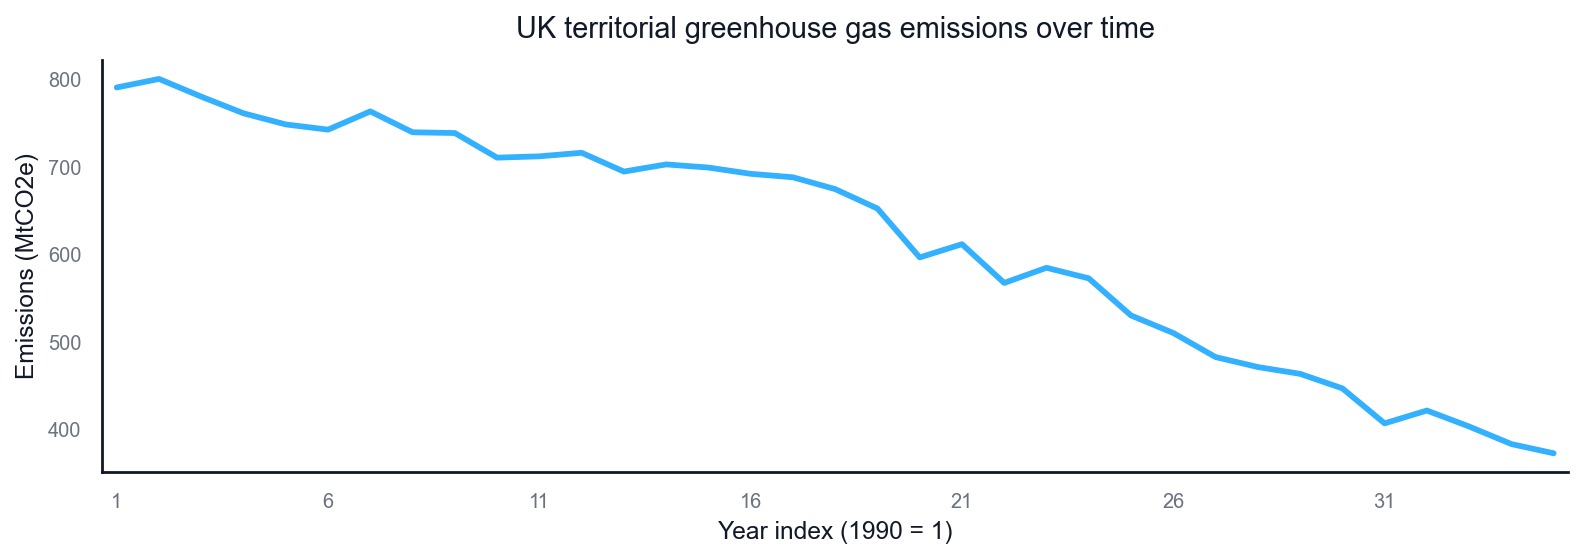

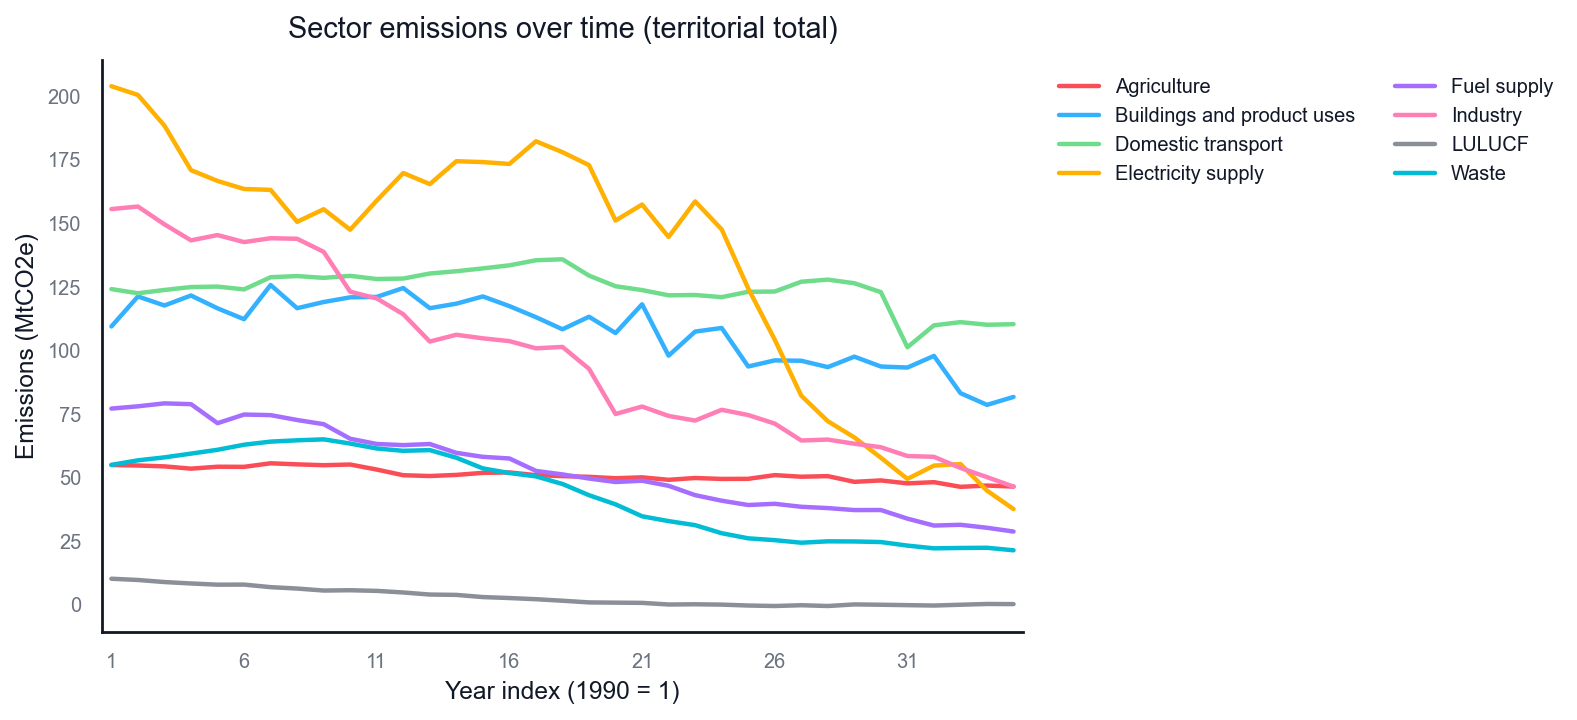

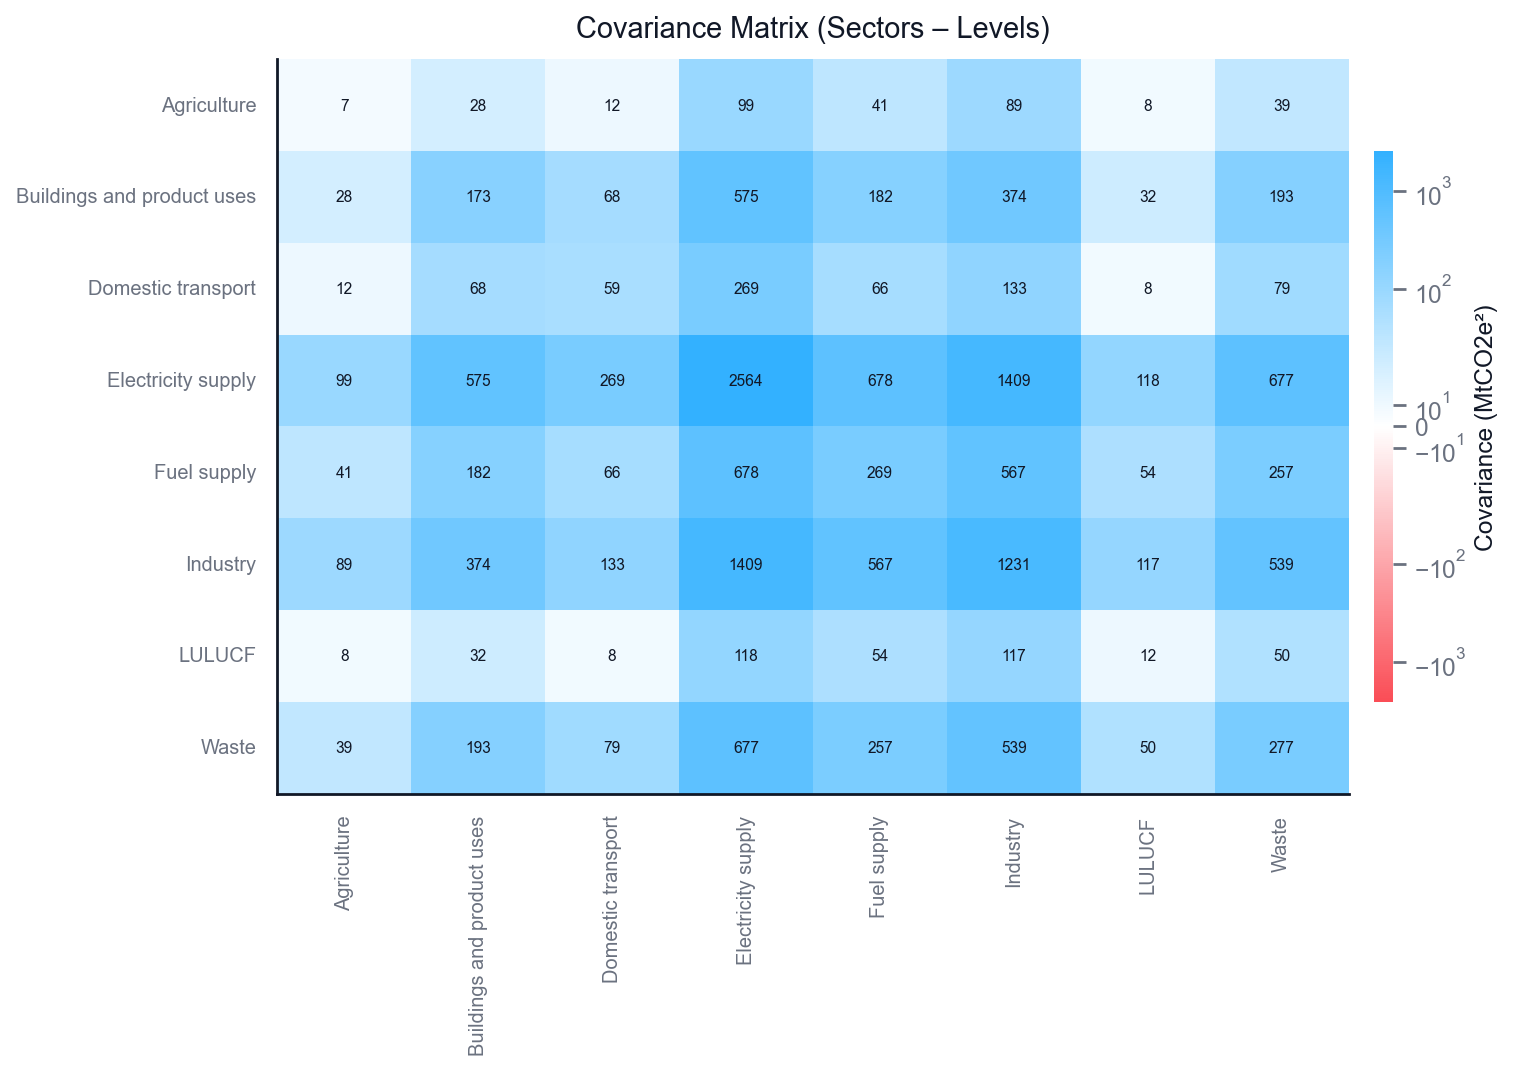

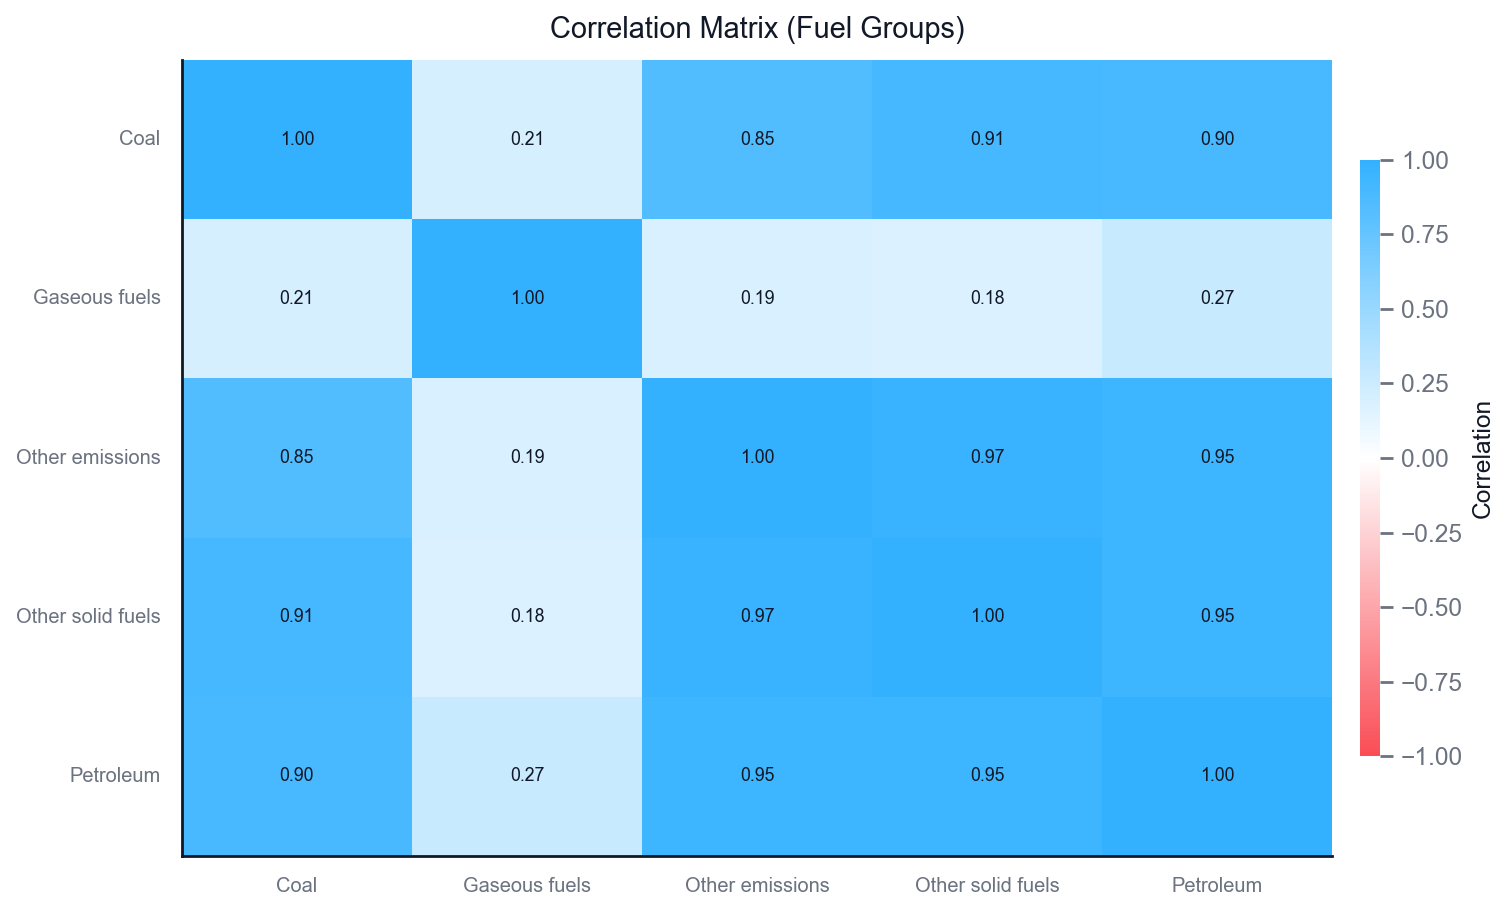

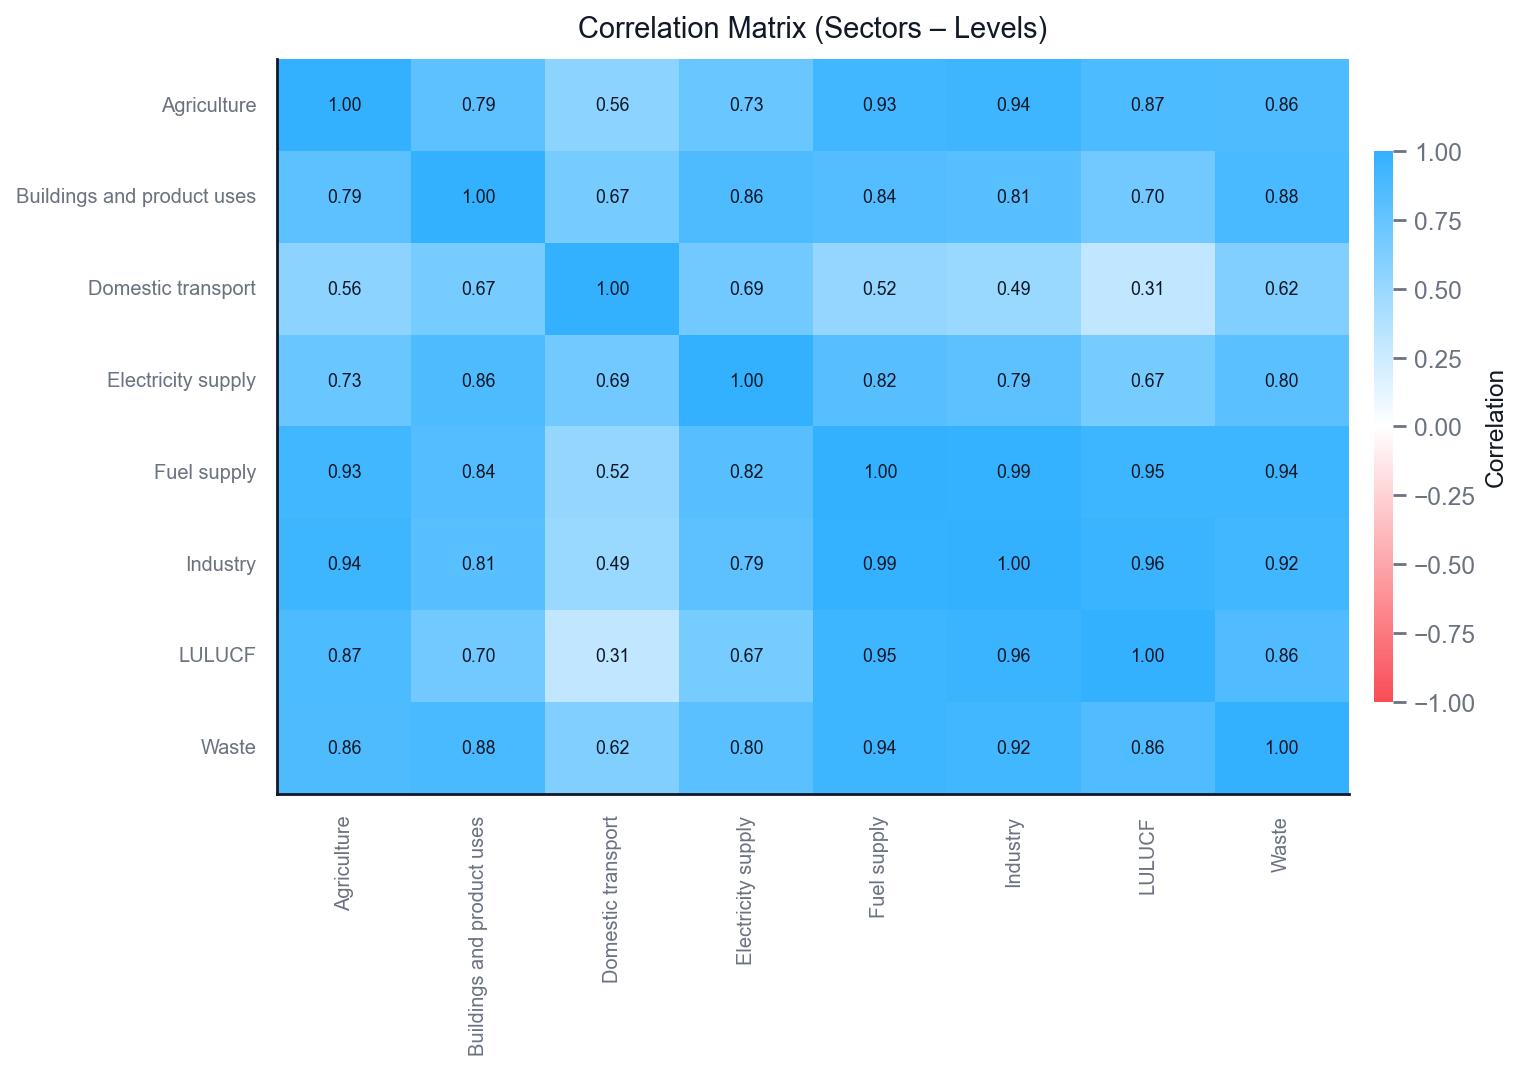

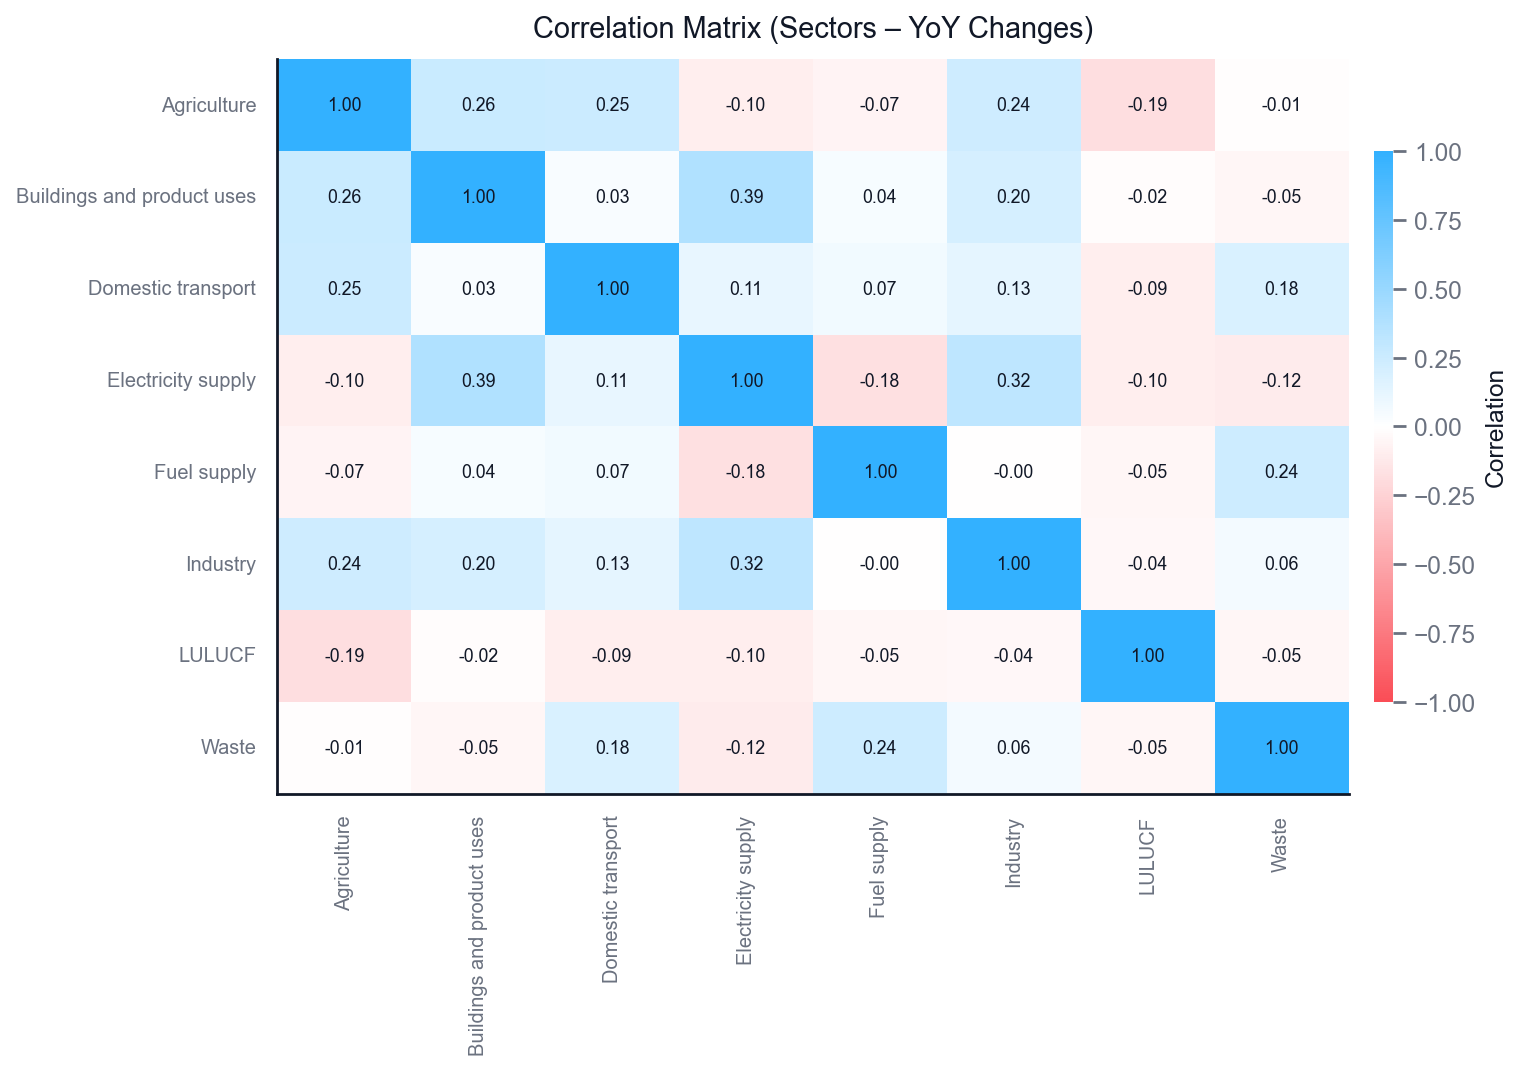

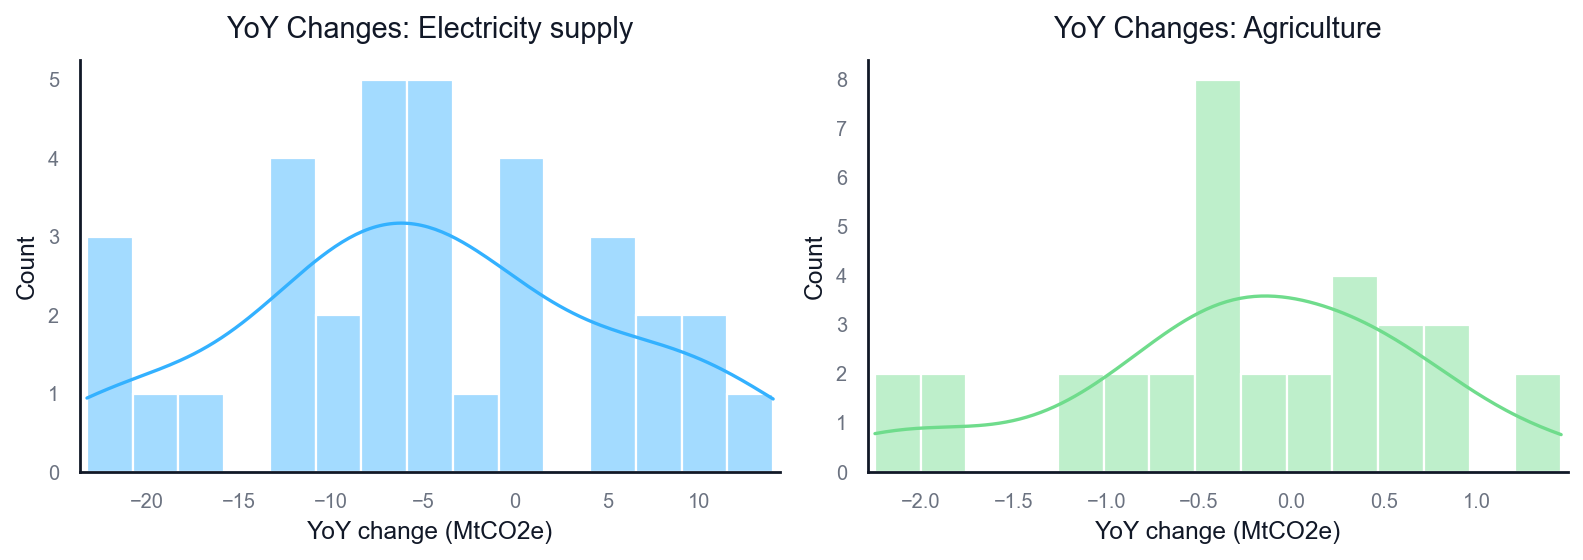

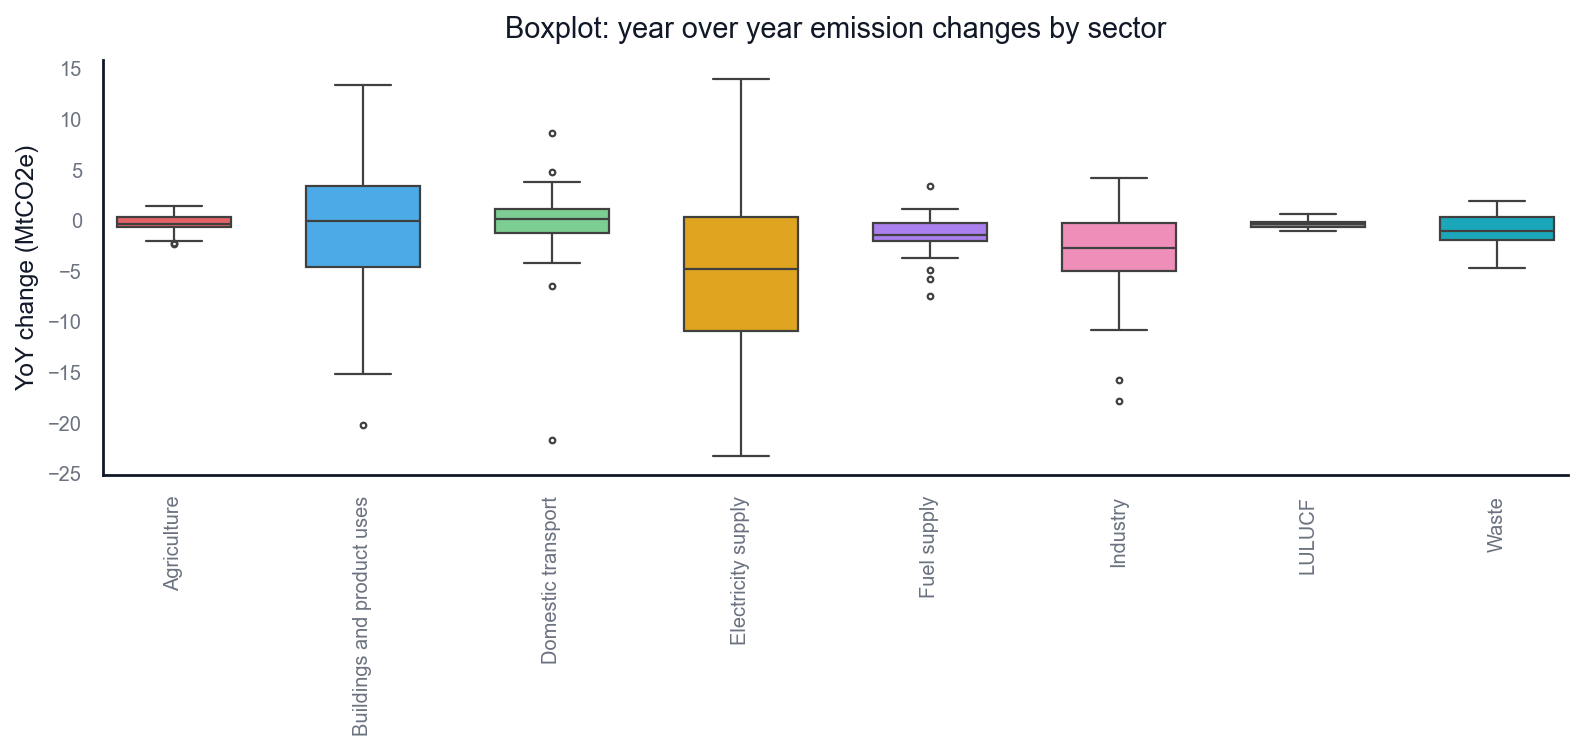

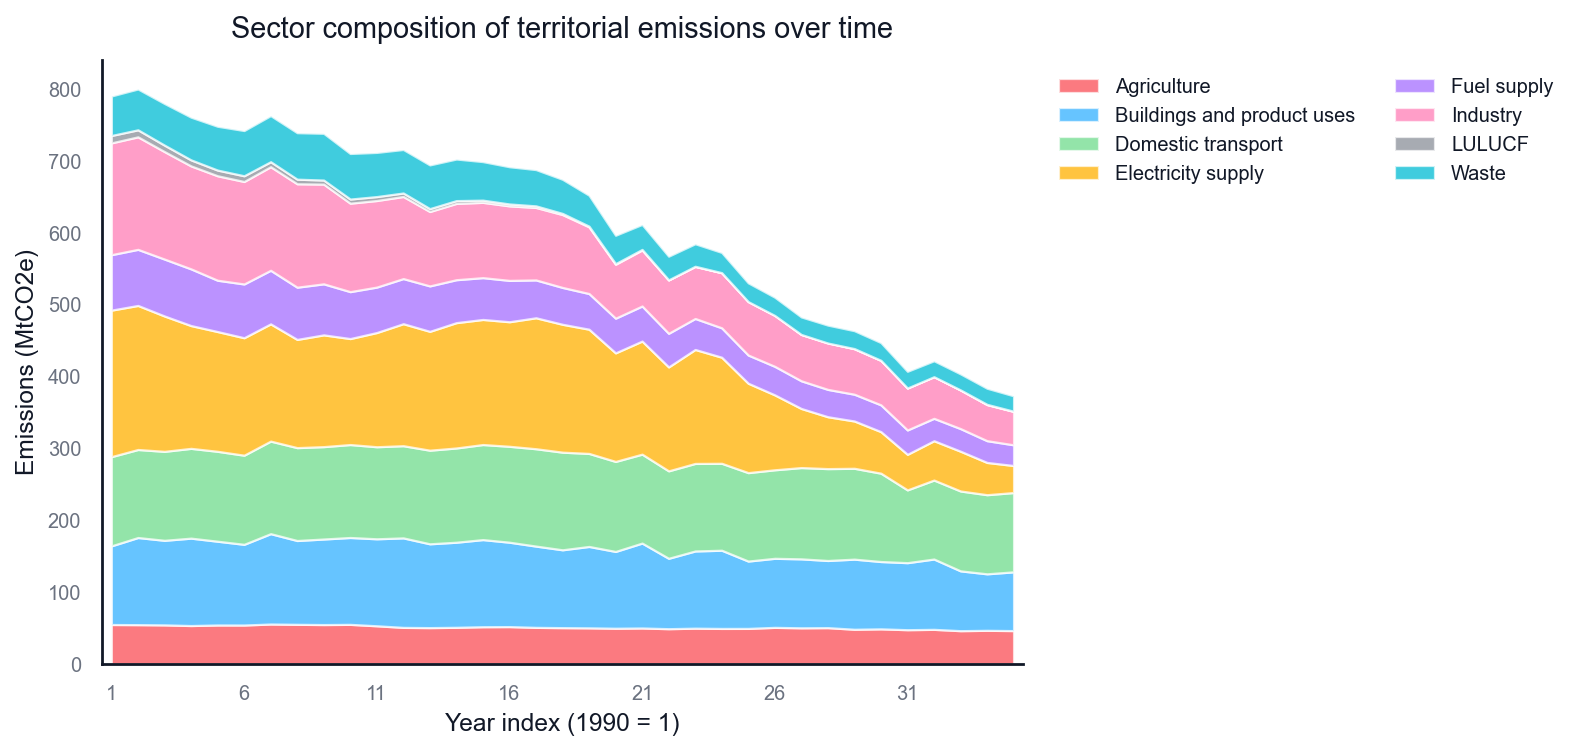

In [59]:
# Visualisation of emission patterns (sectors + YoY)

set_clean_theme()

BASE_YEAR = 1990
sector_col = SECTOR_COL if "SECTOR_COL" in globals() else "Territorial Emissions Statistics sector"
value_col = "Emissions (MtCO2e)"

# Fixed figure width for ALL plots
FIG_W = 10

# Unified heatmap style (same colormap + same small right-side colorbar)
corr_cmap = LinearSegmentedColormap.from_list("corr_custom", [COL_RED, "white", COL_BLUE], N=256)
CBAR_UNI = {"shrink": 0.75, "pad": 0.02, "aspect": 30}

# Better covariance scaling (keeps sign + reveals smaller structure)
from matplotlib.colors import SymLogNorm

# Ensure a compact year index for plotting
territorial = territorial.copy()
territorial = territorial[territorial["Year"] >= BASE_YEAR]
if "Year_idx" not in territorial.columns:
    territorial["Year_idx"] = territorial["Year"] - BASE_YEAR + 1

# Ensure sector-by-year matrix exists (levels)
if "pivot_sec" not in globals():
    pivot_sec = (
        territorial.groupby(["Year", sector_col])[value_col]
        .sum()
        .reset_index()
        .pivot(index="Year", columns=sector_col, values=value_col)
        .fillna(0.0)
        .sort_index()
    )

sectors = pivot_sec.columns.tolist()

# Compute YoY changes once
diff_sec = pivot_sec.diff().dropna()

# Ensure covariance and correlation matrices exist (manual)
if "cov_matrix" not in globals() or "corr_matrix" not in globals():
    cov_matrix = pd.DataFrame(index=sectors, columns=sectors, dtype=float)
    corr_matrix = pd.DataFrame(index=sectors, columns=sectors, dtype=float)
    for s1 in sectors:
        for s2 in sectors:
            cov_matrix.loc[s1, s2] = covariance(pivot_sec[s1].values, pivot_sec[s2].values)
            corr_matrix.loc[s1, s2] = correlation(pivot_sec[s1].values, pivot_sec[s2].values)

if "diff_corr_matrix" not in globals():
    diff_corr_matrix = pd.DataFrame(index=sectors, columns=sectors, dtype=float)
    for s1 in sectors:
        for s2 in sectors:
            diff_corr_matrix.loc[s1, s2] = correlation(diff_sec[s1].values, diff_sec[s2].values)

# -------------------------
# Tables (report-style)
# -------------------------

sec_change = pd.DataFrame({"1990": pivot_sec.iloc[0], "2024": pivot_sec.iloc[-1]})
sec_change["pct_change_1990_2024"] = (sec_change["2024"] - sec_change["1990"]) / sec_change["1990"].abs() * 100
print("Table 1. Sector emissions and percent change (1990 to 2024)")
display(sec_change.round(2))

years_levels = pivot_sec.index.values
years_diff = diff_sec.index.values
trend_levels = pd.Series({s: correlation(years_levels, pivot_sec[s].values) for s in sectors})
trend_diff = pd.Series({s: correlation(years_diff, diff_sec[s].values) for s in sectors})
trend_df = pd.DataFrame({"corr_year_levels": trend_levels, "corr_year_yoy": trend_diff})
trend_df = trend_df.loc[trend_levels.sort_values().index]
print("Table 2. Trend strength by sector (correlation with year, levels vs YoY)")
display(trend_df.round(3))

diff_stats = diff_sec.agg(["mean", "std", "min", "max"]).T
print("Table 3. YoY changes by sector (summary statistics, MtCO2e)")
display(diff_stats.round(2))

# -------------------------
# Plots (ALL width = 10)
# -------------------------

# Plot 1: Total territorial emissions (levels)
tot = territorial.groupby(["Year", "Year_idx"])[value_col].sum().reset_index().sort_values("Year")
fig, ax = plt.subplots(figsize=(FIG_W, 3.6))
sns.lineplot(data=tot, x="Year_idx", y=value_col, ax=ax, color=COL_BLUE, linewidth=2.6)
ax.set_title("UK territorial greenhouse gas emissions over time", pad=10)
ax.set_xlabel(f"Year index ({BASE_YEAR} = 1)")
ax.set_ylabel("Emissions (MtCO2e)")
sparse_xticks(ax, tot["Year_idx"].values, step=5)
clean_ax(ax)
plt.tight_layout()
plt.show()

# Plot 2: Sector trajectories (levels)
sec_long = (
    territorial.groupby([sector_col, "Year", "Year_idx"])[value_col]
    .sum()
    .reset_index()
    .sort_values([sector_col, "Year"])
)
fig, ax = plt.subplots(figsize=(FIG_W, 4.6))
sns.lineplot(
    data=sec_long, x="Year_idx", y=value_col, hue=sector_col,
    palette=SECTOR_PALETTE, linewidth=2.0, ax=ax
)
ax.set_title("Sector emissions over time (territorial total)", pad=10)
ax.set_xlabel(f"Year index ({BASE_YEAR} = 1)")
ax.set_ylabel("Emissions (MtCO2e)")
sparse_xticks(ax, np.sort(sec_long["Year_idx"].unique()), step=5)
clean_ax(ax)
ax.legend(frameon=False, ncol=2, bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9, title=None)
plt.tight_layout()
plt.show()

# Plot 3: Covariance heatmap (levels) with unified small colorbar
cov_vals = cov_matrix.astype(float).values
cov_absmax = np.nanmax(np.abs(cov_vals))
cov_norm = SymLogNorm(
    linthresh=max(1.0, 0.02 * cov_absmax),
    vmin=-cov_absmax,
    vmax=cov_absmax
)

fig, ax = plt.subplots(figsize=(FIG_W, 6.8))
sns.heatmap(
    cov_matrix.astype(float),
    cmap=corr_cmap,
    norm=cov_norm,
    annot=True, fmt=".0f",
    annot_kws={"size": 7, "color": COL_DARK},
    square=False,
    cbar_kws={**CBAR_UNI, "label": "Covariance (MtCO2e²)"},
    ax=ax
)
ax.set_title("Covariance Matrix (Sectors – Levels)", pad=10)
clean_ax(ax)
plt.tight_layout()
plt.show()

# Plot 4: Correlation heatmap (fuel groups) with unified small colorbar
fig, ax = plt.subplots(figsize=(FIG_W, 5.8))
sns.heatmap(
    fuel_corr.astype(float),
    vmin=-1, vmax=1,
    cmap=corr_cmap,
    annot=True, fmt=".2f",
    annot_kws={"size": 8, "color": COL_DARK},
    square=False,
    cbar_kws={**CBAR_UNI, "label": "Correlation"},
    ax=ax
)
ax.set_title("Correlation Matrix (Fuel Groups)", pad=10)
clean_ax(ax)
plt.tight_layout()
plt.show()

# Plot 5: Correlation heatmap (sectors – levels) with unified small colorbar
fig, ax = plt.subplots(figsize=(FIG_W, 6.8))
sns.heatmap(
    corr_matrix.astype(float),
    vmin=-1, vmax=1,
    cmap=corr_cmap,
    annot=True, fmt=".2f",
    annot_kws={"size": 8, "color": COL_DARK},
    square=False,
    cbar_kws={**CBAR_UNI, "label": "Correlation"},
    ax=ax
)
ax.set_title("Correlation Matrix (Sectors – Levels)", pad=10)
clean_ax(ax)
plt.tight_layout()
plt.show()

# Plot 6: Correlation heatmap (sectors – YoY changes) with unified small colorbar
fig, ax = plt.subplots(figsize=(FIG_W, 6.8))
sns.heatmap(
    diff_corr_matrix.astype(float),
    vmin=-1, vmax=1,
    cmap=corr_cmap,
    annot=True, fmt=".2f",
    annot_kws={"size": 8, "color": COL_DARK},
    square=False,
    cbar_kws={**CBAR_UNI, "label": "Correlation"},
    ax=ax
)
ax.set_title("Correlation Matrix (Sectors – YoY Changes)", pad=10)
clean_ax(ax)
plt.tight_layout()
plt.show()

# Plot 7: Histograms of YoY changes (two representative sectors) with fixed figure width
fig, axes = plt.subplots(1, 2, figsize=(FIG_W, 3.6))

sns.histplot(
    diff_sec["Electricity supply"],
    bins=15, kde=True,
    ax=axes[0],
    alpha=0.45,
    color=COL_BLUE,
    edgecolor=None
)
axes[0].set_title("YoY Changes: Electricity supply", pad=10)
axes[0].set_xlabel("YoY change (MtCO2e)")
axes[0].set_ylabel("Count")
clean_ax(axes[0])

sns.histplot(
    diff_sec["Agriculture"],
    bins=15, kde=True,
    ax=axes[1],
    alpha=0.45,
    color=COL_GREEN,
    edgecolor=None
)
axes[1].set_title("YoY Changes: Agriculture", pad=10)
axes[1].set_xlabel("YoY change (MtCO2e)")
axes[1].set_ylabel("Count")
clean_ax(axes[1])

plt.tight_layout()
plt.show()

# Plot 8: Boxplot of YoY changes across sectors with fixed figure width
diff_long = diff_sec.reset_index().melt(id_vars=["Year"], var_name="Sector", value_name="YoY_change")
fig, ax = plt.subplots(figsize=(FIG_W, 4.8))
sns.boxplot(
    data=diff_long, x="Sector", y="YoY_change",
    order=sectors, hue="Sector", palette=SECTOR_PALETTE,
    dodge=False, width=0.6, fliersize=2.5, linewidth=1.0,
    ax=ax, legend=False
)
for artist in ax.artists:
    artist.set_alpha(0.40)
ax.set_title("Boxplot: year over year emission changes by sector", pad=10)
ax.set_xlabel("")
ax.set_ylabel("YoY change (MtCO2e)")
ax.tick_params(axis="x", rotation=90, labelsize=9)
clean_ax(ax)
plt.tight_layout()
plt.show()

# Plot 9: Stacked area showing sector composition (levels) with fixed figure width
t = (pivot_sec.index.values - pivot_sec.index.min()) + 1
year0 = int(pivot_sec.index.min())

fig, ax = plt.subplots(figsize=(FIG_W, 4.8))
ax.stackplot(
    t,
    np.vstack([pivot_sec[c].values for c in sectors]),
    labels=sectors,
    alpha=0.75,
    colors=[SECTOR_PALETTE[i % len(SECTOR_PALETTE)] for i in range(len(sectors))]
)
ax.set_title("Sector composition of territorial emissions over time", pad=10)
ax.set_xlabel(f"Year index ({year0} = 1)")
ax.set_ylabel("Emissions (MtCO2e)")
sparse_xticks(ax, t, step=5)
clean_ax(ax)
ax.legend(frameon=False, ncol=2, bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9, title=None)
plt.tight_layout()
plt.show()

The combined statistical and graphical analysis suggests that UK territorial emissions exhibit strong positive co-movement across most sectors in levels, reflecting broad-based decarbonisation since 1990. However, correlations in year-over-year changes are substantially weaker, indicating that part of the co-movement is driven by common long-run decline rather than synchronized short-run adjustments. The pronounced reduction in electricity supply, closely linked to the phase-out of coal, emerges as a central driver of overall emission decline. Other sectors, such as industry and buildings, follow similar downward trajectories but with varying speed and volatility. These findings suggest that while structural decarbonisation is occurring economy-wide, the distribution of emission reductions is heterogeneous across sectors. This completes the analysis of structural co-movement and provides the empirical foundation for clustering subsectors based on their emission trajectories.

Having established patterns of sectoral co-movement, we now examine whether subsectors can be grouped into structurally distinct clusters based on the full shape of their emission trajectories. Rather than focusing on pairwise relationships, the clustering analysis identifies broader structural groupings that may reflect differences in technological transition, policy exposure, or abatement difficulty.

---
# Question 2
## Cluster Analysis
Cluster analysis is used to group data points based on similarity in their attributes.
1. Chooseoneclusteringalgorithmdiscussedinthelecturesandapplyittogroupemissionsources
or activities based on their emission trajectories over time.
2. Clearlyjustifythevariablesusedforclustering(e.g.,emissionlevels,rateofchange,fuelgroup).
Interpret the resulting clusters and explain what they reveal about structural changes in UK
greenhouse gas emissions.
3. Relate your clustering results to UK climate policy by identifying which clusters align with
sectorstargeted under UKCarbonBudgets and which sectorsappear moreresistant toemission
reductions.
---

In [61]:
# Subsector time series
SUB_COL = "Territorial Emissions Statistics subsector"

sub_year = (
    territorial
    .groupby(["Year", SUB_COL], as_index=False)["Emissions (MtCO2e)"]
    .sum()
)

pivot_sub = (
    sub_year
    .pivot(index="Year", columns=SUB_COL, values="Emissions (MtCO2e)")
    .fillna(0.0)
    .sort_index()
)

# Transpose so rows = subsectors, columns = years
X = pivot_sub.T
print("Shape:", X.shape)
X.head()

Shape: (27, 35)


Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Territorial Emissions Statistics subsector,,,,,,,,,,,,,,,,,,,,,
Agricultural combustion,4.325499,4.499649,4.668857,4.424387,4.450208,4.574767,4.979039,4.690097,4.555080,5.043046,...,6.575694,6.380964,6.332409,4.798576,5.104755,5.224523,5.140008,4.144526,5.201700,5.855751
Agricultural soils,14.526131,14.623143,13.924617,13.348997,13.923282,13.984590,14.239490,14.318589,14.054559,14.080221,...,12.808333,12.496116,12.650881,12.523147,12.763325,11.896074,12.302954,11.593226,11.693428,11.093132
Bioenergy crops,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.006565,-0.012377,-0.015531,-0.003829,-0.021312,-0.008765,-0.016776,-0.010148,-0.028153,0.001828
Civil aviation,1.494801,1.509820,1.509616,1.480041,1.378973,1.462233,1.616538,1.641061,1.732712,1.938997,...,1.529931,1.467114,1.563166,1.426500,1.341422,0.571256,0.762536,1.071080,1.132249,1.182713
Commercial buildings,12.473368,14.381214,13.103239,14.030387,13.713749,14.216497,15.177762,13.423471,14.580264,15.925649,...,12.784026,12.458749,11.937840,14.073720,13.346142,13.134891,14.118867,13.208619,12.693438,13.354014


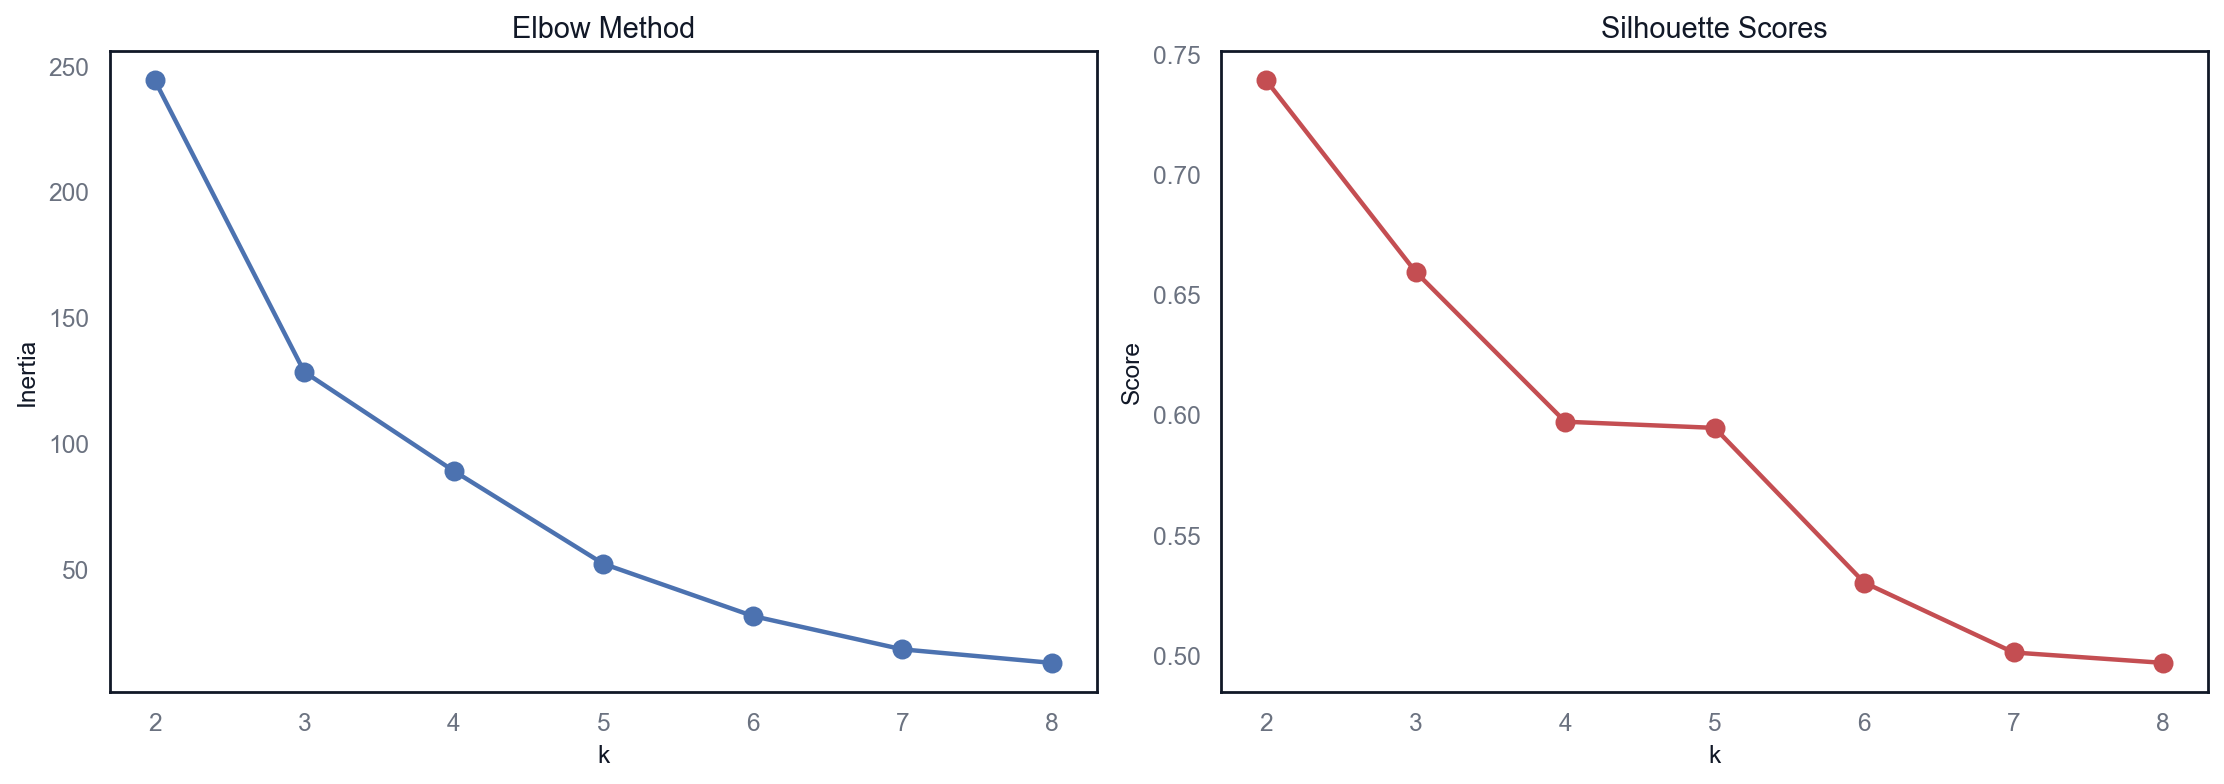

In [62]:
# Scale trajectories
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow and silhouette
inertias = []
silhouettes = []
k_range = range(2, 9)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(list(k_range), inertias, "bo-", linewidth=2, markersize=8)
axes[0].set_title("Elbow Method")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Inertia")
axes[0].grid(True)

axes[1].plot(list(k_range), silhouettes, "ro-", linewidth=2, markersize=8)
axes[1].set_title("Silhouette Scores")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Score")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [66]:
# k to report
k = 3

# Infer subsector names from the unscaled feature DataFrame (preferred)
if "X" in globals() and hasattr(X, "index"):
    idx = X.index
elif "pivot_sub" in globals() and hasattr(pivot_sub, "index"):
    idx = pivot_sub.index
elif "pivot_subsec" in globals() and hasattr(pivot_subsec, "index"):
    idx = pivot_subsec.index
elif "subsector_names" in globals():
    idx = pd.Index(subsector_names)
else:
    raise NameError("Could not infer subsector names. Keep the DataFrame you scaled (with an index) as X.")

# Fit K-Means on the scaled data (NumPy array or DataFrame both work)
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_scaled)

# Map subsector name -> cluster id
cluster_map = pd.Series(labels, index=idx, name="cluster").astype(int)

# Print clusters in your preferred format
for c in sorted(cluster_map.unique()):
    members = sorted(cluster_map[cluster_map == c].index.tolist())
    print(f"Cluster {c} ({len(members)} subsectors):")
    for m in members:
        print(f"  - {m}")
    print()


Cluster 0 (20 subsectors):
  - Agricultural combustion
  - Agricultural soils
  - Bioenergy crops
  - Civil aviation
  - Commercial buildings
  - Cropland mineral soils change
  - Forestry
  - Grassland mineral soils change
  - Industrial processes
  - Other LULUCF
  - Other agriculture
  - Other buildings and product uses
  - Other domestic transport
  - Other industry
  - Peatland
  - Public sector buildings
  - Railways
  - Settlement
  - Solid fuel supply
  - Waterborne

Cluster 1 (2 subsectors):
  - Power stations
  - Road

Cluster 2 (5 subsectors):
  - Industrial fuel combustion
  - Livestock
  - Oil and gas supply
  - Residential buildings
  - Waste



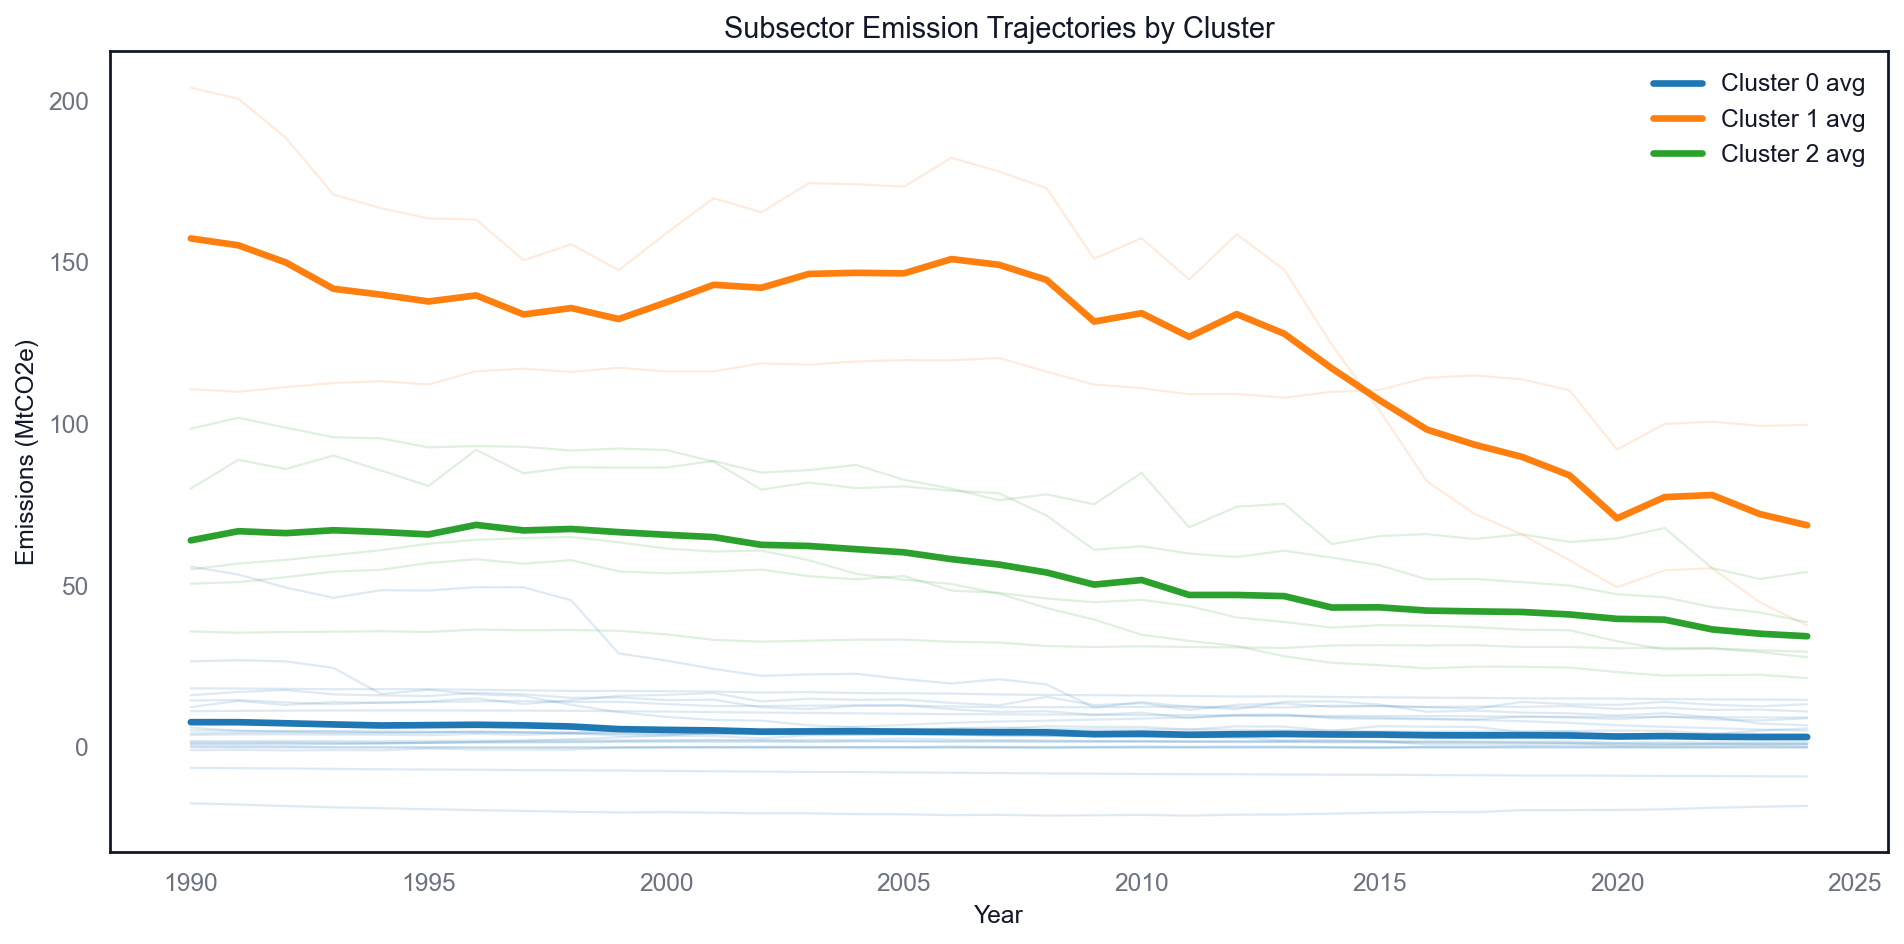

In [67]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

fig, ax = plt.subplots(figsize=(12, 6))
for c in range(k):
    members = cluster_map[cluster_map == c].index.tolist()
    for m in members:
        ax.plot(pivot_sub.index, pivot_sub[m], color=colors[c], alpha=0.15, linewidth=1)
    ax.plot(pivot_sub.index, pivot_sub[members].mean(axis=1),
            color=colors[c], linewidth=3, label=f"Cluster {c} avg")

ax.set_title("Subsector Emission Trajectories by Cluster")
ax.set_xlabel("Year")
ax.set_ylabel("Emissions (MtCO2e)")
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

In [68]:
# Cluster summary
summary = pd.DataFrame(index=range(k))
for c in range(k):
    members = cluster_map[cluster_map == c].index.tolist()
    summary.loc[c, "n_subsectors"] = len(members)
    summary.loc[c, "avg_1990"] = pivot_sub[members].iloc[0].mean()
    summary.loc[c, "avg_latest"] = pivot_sub[members].iloc[-1].mean()
    summary.loc[c, "avg_pct_change"] = (
        (pivot_sub[members].iloc[-1].mean() - pivot_sub[members].iloc[0].mean())
        / abs(pivot_sub[members].iloc[0].mean()) * 100
    )

display(summary.round(2))

,n_subsectors,avg_1990,avg_latest,avg_pct_change
0,20.0,7.80,3.21,-58.85
1,2.0,157.39,68.69,-56.36
2,5.0,64.02,34.37,-46.31


**Variable justification (Q2.2).** We cluster the 27 subsectors directly on their 35-year emission trajectories (1990-2024), scaled with StandardScaler. This captures the full shape of each time series rather than relying on summary statistics. Scaling is necessary because subsector emissions range from near-zero (Bioenergy crops) to over 180 MtCO2e (Power stations), and without it K-Means would simply separate large from small emitters. We select k=3 based on the elbow at k=3 in the inertia plot and a strong silhouette score of 0.66.

**Cluster interpretation.** Cluster 1 (Power stations, Road transport) contains the two dominant emitters, averaging 157 MtCO2e in 1990 with a 56% reduction by 2024. Cluster 2 (Industrial fuel combustion, Livestock, Oil and gas supply, Residential buildings, Waste) captures mid-sized emitters averaging 64 MtCO2e in 1990, with the slowest decline at 46%. Cluster 0 groups the remaining 20 small subsectors (avg 7.8 MtCO2e in 1990), collectively down 59%.

**Policy relevance (Q2.3).** Cluster 1 aligns with the sectors most directly targeted by UK Carbon Budgets: coal phase-out drove the steep Power stations decline, while Road transport is a key focus of the sixth Carbon Budget through EV adoption. Cluster 2 represents the "harder to abate" sectors. Livestock and Industrial combustion require process-level changes rather than fuel switching, and Residential buildings depend on the slow rollout of heat pumps. Their 46% decline, the weakest of all three clusters, flags these as the main risk to meeting future carbon budgets. Cluster 0's broad-based 59% reduction suggests structural decarbonisation is occurring across the wider economy, even among individually minor sources.

# Question 3
## Policy Interpretation and Critical Analysis
1. Using the column Included in UK territorial total, compare emission trends with and
without international aviation and shipping. Discuss how this distinction affects progress as-
sessment against UK Carbon Budgets.
2. UsingtheIncluded in UK Paris Agreement total indicator,identifywhichemissionsources
arecoveredundertheUK’sParisAgreementreporting. Explaintheimplicationsofthiscoverage
for interpreting national emission reduction performance.
3. Based on your data-driven findings, critically assess whether historical emission trends suggest
that the UK is structurally aligned with its long-term climate targets. Support your answer with
quantitative evidence from your analysis.